In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle

stochasitc_tensor가 필요한 이유는 vae 에서는 값이 아니라, encoding layer의 결과로,
distribution이 나온다. 그렇기 때문에, 해당 분포에서 sample 을 draw하여, 이를 tensor에 
태워야 하기 때문에 필요하다. 



In [32]:
try:
    st = tf.contrib.bayesflow.stochastic_tensor
except:
  # doesn't exist in later versions of TF
  # we will use the reparameterization trick instead
  # watch the later lecture on the reparameterization trick
  # to learn about it.
  pass
Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli

In [33]:
print(st)

None


In [4]:
d = [1,2,3,4,5]
d[:-1]

[1, 2, 3, 4]

In [8]:
xx

<tf.Tensor 'Placeholder_3:0' shape=(?, 784) dtype=float32>

In [34]:
# Layer 를 build 할 때, 기본적으로 activation function은 relu function 이다  
class DenseLayer(object):
    def __init__(self, M1, M2, f = tf.nn.relu):
        self.weight = tf.Variable(tf.random_normal(shape=(M1, M2))*2 / np.sqrt(M1))
        self.bias = tf.Variable(np.zeros(M2).astype(np.float32))
        self.forwardFunction = f
    
    # forward operation :  Wx+b인 값을 forward function에 통과시키는 것.
    def forward(self, X):
        return self.forwardFunction(tf.matmul(X, self.weight) + self.bias)

    

st = None    
class VariationalAutoencoder:
    ## input 의 차원
    ## hidden_layer_size 는 이것의 output 이 layerZ 의 final size가 되고, 이것은 decoder input의 size 가 된다. 
    def __init__(self, dimension, hidden_layer_sizes):
        
        self.X = tf.placeholder(tf.float32, shape=(None,dimension))
        
        self.encoder_layers = []
        M_in = dimension
        
        ## encoder 의 layer를 구성할 때, 마지막 layer는 빼고, 알아서 구성하였다. 
        # 그런데, encoder layer의 마지막은 softplus activation function을 쓰고 싶어서
        # [:-1] 해줌.
        for M_out in hidden_layer_sizes[:-1]:
            hiddenLayer = DenseLayer(M_in, M_out)
            self.encoder_layers.append(hiddenLayer)
            M_in = M_out
         
        
        # hidden layer의 마지막 size (activation function처리를 다르게하기 위해)
        M = hidden_layer_sizes[-1]
        
        ## 일단, encoder의 output은 mean, stddev를 return 한다. 
        ## mean은 activation 통과할 필요없고, stddev는 softplus 인 activation function을 
        ## 통과해야 한다. 그래서 따로 layer를 정의한다. 
        # 따라서 2차원 gaussian으로 진행해야 하므로, output size가 2*m 이다.
        h = DenseLayer(M_in, 2*M, f=lambda x: x)
        self.encoder_layers.append(h)
        
        ## encoding layer의 output을 기록한다. 
        current_layer_value = self.X
        for layer in self.encoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        
        # encoding layer의 output을 seperate 해서, stddev 부분은 softplus를 적용한다.
        self.means = current_layer_value[:, :M]
        self.stddev = tf.nn.softplus(current_layer_value[:, M:]) + 1e-6
        
        ## sampling을 수행하기 앞서, 
        if st is None:
            standard_normal = Normal(
                loc=np.zeros(M, dtype=np.float32),
                scale = np.ones(M, dtype=np.float32)    
            )
        
            ## 여기서는 stdNormal 즉, N(0,1) 에서 얻어낸 값을 적당히 곱하고 더해서, 
            ## N(mean,stddev) 에서 추출한 것과 같이 되도록 조정해준다. 
            ## 이것이 encoder의 output 분포에서 추출한 분포이다. 
            e = standard_normal.sample(tf.shape(self.means)[0])
        
            ## 마지막 hiddenLayerSize * (latenSpace 수) 만큼의 sample 추출. 
            self.Z = e*self.stddev + self.means
        else:
             with st.value_type(st.SampleValue()):
                self.Z = st.StochasticTensor(Normal(loc=self.means, scale=self.stddev))
        
        
        self.decoder_layers=[]
        M_in = M
        
        ## encoder layer와는 반대로 진행한다. 
        for M_out in reversed(hidden_layer_sizes[: -1]):
            ## babakc
            self.decoder_layers.append( DenseLayer(M_in, M_out))
            M_in = M_out 
        
        #  마지막 hidden layer는 activation function을 안준다.(그냥y=x)
        # 
        h = DenseLayer(M_in, dimension, f=lambda x: x)
        self.decoder_layers.append(h)
        
        # get posterior_predictive_logits
        current_layer_value = self.Z
        for layer in self.decoder_layers:
            current_layer_value = layer.forward(current_layer_value)
        posterior_predictive_logits = current_layer_value
        
        ## get the output
        self.X_hat_distribution = Bernoulli(logits=posterior_predictive_logits)
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(posterior_predictive_logits)
        
        if st is None:
            kl = -tf.log(self.stddev) + 0.5*(self.stddev**2 + self.means**2) - 0.5
            kl = tf.reduce_sum(kl,axis=1)
        else:
            kl = tf.reduce_sum(
                tf.contrib.distributions.kl_divergence(
                    self.Z.distribution, standard_normal
                ),
                1
            )
            
        expected_log_likelihood = tf.reduce_sum(self.X_hat_distribution.log_prob(self.X),1)
        
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
        
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
    
    def fit(self, X, epochs=30, batch_size=64):
        costs = []
        n_batches = len(X) // batch_size
        print("N-batchs : ", n_batches)
        for i in range(epochs):
            print("epoch: ",i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_size:(j+1)*batch_size]
                _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
                c /= batch_size
                costs.append(c)
                if j%100 == 0:
                    print("iter: %d, cost : %.3f" %(j,c))
        
        plt.plot(costs)
        plt.show()
       
   
    def transform(self,X):
        return self.sess.run(
        self.means, feed_dict={self.X:X}
        )
    
    def posterior_predictive_sample(self, X):
        return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})
    
    
                    
                                

In [8]:


def get_mnist_from_csv(limit=None):
    df = pd.read_csv('../data/train.csv')
    data = df.values
  # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y


X, Y = get_mnist_from_csv()
  # convert X to binary variable
X = (X > 0.5).astype(np.float32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
N-batchs :  656
epoch:  0
iter: 0, cost : -1342.977
iter: 100, cost : -232.993
iter: 200, cost : -198.820
iter: 300, cost : -192.272
iter: 400, cost : -164.958
iter: 500, cost : -162.447
iter: 600, cost : -163.899
epoch:  1
iter: 0, cost : -152.373
iter: 100, cost : -136.988
iter: 200, cost : -142.850
iter: 300, cost : -139.916
iter: 400, cost : -134.666
iter: 500, cost : -139.563
iter: 600, cost : -127.478
epoch:  2
iter: 0, cost : -140.025
iter: 100, cost : -136.613
iter: 200, cost : -127.211
iter: 300, cost : -131.685
iter: 400, cost : -131.968
iter: 500, cost : -118.024
iter: 600, cost : -120.200
epoch:  3
iter: 0, cost : -127.200
iter: 100, cost : -127.131
iter: 200, cost : -123.997
iter: 300, cost : -110.061
iter: 400, cost : -122.612
iter: 500, cost : -119.038
iter: 600,

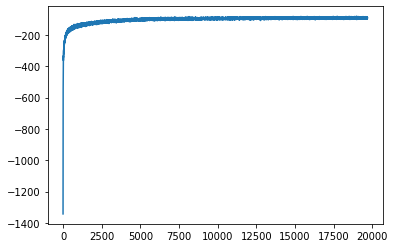

In [35]:
vae = VariationalAutoencoder(784, [200, 100])
vae.fit(X)


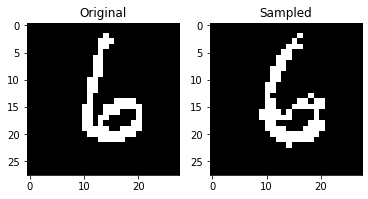

Generate another?y


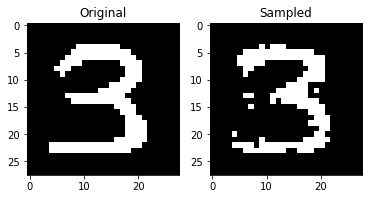

Generate another?d


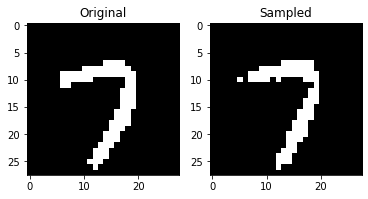

Generate another?23


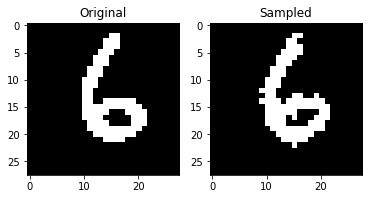

Generate another?3


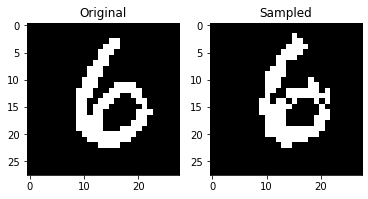

Generate another?n


In [36]:
done = False
while not done:
    i = np.random.choice(len(X))
    x = X[i]
    im = vae.posterior_predictive_sample([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Sampled")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True

In [2]:
M=20
xx = tf.placeholder(tf.float32, shape=(None, 100))
print(tf.shape(xx[:,:50])[0])

Normal = tf.contrib.distributions.Normal
standard_normal = Normal(
            loc=np.zeros(M, dtype=np.float32),
            scale = np.ones(M, dtype=np.float32)    
        )
ttemp = standard_normal.sample(tf.shape(xx[:,:50])[0])
ttemp

Tensor("strided_slice_1:0", shape=(), dtype=int32)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


<tf.Tensor 'Normal/sample/Reshape_1:0' shape=(?, 20) dtype=float32>

In [3]:
ttemp

<tf.Tensor 'Normal/sample/Reshape_1:0' shape=(?, 20) dtype=float32>